In [1]:
# install SNN-Toolbox from local modified version
!pip install /content/drive/My\ Drive/GitHub/spiking-p3-gtnumbers/snn_toolbox

Processing ./drive/My Drive/GitHub/spiking-p3-gtnumbers/snn_toolbox
  Created wheel for snntoolbox: filename=snntoolbox-0.4.1-py2.py3-none-any.whl size=195127 sha256=b55056098ac3b8c5b6021f0775932f8ff6d4c51ff2b9a5881463ec12d3fa8400
  Stored in directory: /tmp/pip-ephem-wheel-cache-e2ro3869/wheels/a6/22/3b/c7bbca8a559a101b4cfb0bef50ae45a6e62a1cf48ae44ffcb8
Successfully built snntoolbox


In [2]:
%matplotlib inline

import os
import datetime
import logging
from scipy.io import loadmat
import numpy as np
import keras
from keras.layers import (Conv2D, BatchNormalization, Dropout, AveragePooling2D,
Flatten, Dense, Input)
from keras.models import Sequential
from sklearn.model_selection import cross_val_score, ShuffleSplit
import tensorflow as tf
import snntoolbox
from snntoolbox.utils.utils import import_configparser
from snntoolbox.bin.run import main
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [3]:
# set logging level
logging.basicConfig(level=logging.INFO)
# for replication
np.random.seed(1)
tf.random.set_seed(2)
# set up working directory to store results
out_dir = '/content/drive/My Drive/'
path_wd = os.path.abspath(
    os.path.join(out_dir, 'temp', 'gtn',
                 str(datetime.datetime.now())))
os.makedirs(path_wd)
model_name = 'gtn_model'
model_ext = '.h5'
# load data
datapath = '/content/drive/My Drive/VarekaGTNEpochs.mat'
data = loadmat(datapath)
target = data['allTargetData']
non_target = data['allNonTargetData']
logging.info('Loaded data from file {}.'.format(datapath))

INFO:root:Loaded data from file /content/drive/My Drive/VarekaGTNEpochs.mat.


In [4]:
def discard_damaged(features, labels):
  """
  preprocess data
  """
  threshold = 100.0
  accept_features = []
  accept_labels = []
  for i in range(features.shape[0]):
      discard = False
      # check max values of all channels
      if np.max(np.abs(features[i])) > threshold:
          discard = True
      if not discard:
          accept_features.append(features[i])
          accept_labels.append(labels[i])
  logging.info('Discarded {}% of samples.'.format(
      (1 - len(accept_features) / features.shape[0]) * 100))
  features = np.array(accept_features)
  labels = np.array(accept_labels)
  return features, labels

features = np.concatenate((target, non_target), axis=0)
target_labels = np.tile(np.array([1, 0]), (target.shape[0], 1))
non_target_labels = np.tile(np.array([0, 1]), (non_target.shape[0], 1))
labels = np.vstack((target_labels, non_target_labels))
(features, labels) = discard_damaged(features, labels)
features = np.expand_dims(features, -1)
logging.debug('preprocessed features({}): {})'.format(features.shape, features))
logging.debug('preprocessed labels({}): {})'.format(labels.shape, labels))

INFO:root:Discarded 30.315643426985783% of samples.


In [0]:
def create_base_config():
  """
  Create a config file for SNN Toolbox.
  """
  configparser = import_configparser()
  config = configparser.ConfigParser()
  config['paths'] = {
      'path_wd': path_wd,  # Path to model.
      'dataset_path': path_wd,  # Path to dataset.
      'filename_ann': model_name  # Name of input model.
  }

  config['tools'] = {
      'evaluate_ann': False,  # Test ANN on dataset before conversion.
      'normalize': True  # Normalize weights for full dynamic range.
  }

  config['simulation'] = {
      'simulator': 'INI',  # Chooses execution backend of SNN toolbox.
      'duration': 50,  # Number of time steps to run each sample.
      'num_to_test': 2009,  # How many test samples to run.
      'batch_size': 49,  # Batch size for simulation.
  }

  # config['output'] = {
  #     'plot_vars': {
  #         'spiketrains',
  #         'spikerates',
  #         'activations',
  #         'correlation',
  #         'v_mem',
  #         'error_t'}
  # }
  return config


def write_config(config_name='config', config=None):
  """
  Store config file.
  """
  config_path = os.path.join(path_wd, config_name)
  with open(config_path, 'w') as configfile:
      config.write(configfile)
  logging.info('SNN-Toolbox config file written to {}'.format(config_path))
  return config_path

In [0]:
def create_model():
  """
  Prepare Keras model
  """
  model = Sequential()
  model.add(Conv2D(filters=6, kernel_size=(3, 3),
    activation=keras.activations.elu, input_shape=(3, 1200, 1)))
  model.add(BatchNormalization())
  model.add(Dropout(0.5, seed=0))
  model.add(AveragePooling2D(pool_size=(1, 8)))
  model.add(Flatten())
  model.add(Dense(100, activation=keras.activations.elu))
  model.add(BatchNormalization())
  model.add(Dropout(0.5, seed=0))
  model.add(Dense(2, activation=keras.activations.softmax))
  model.compile(
      optimizer=keras.optimizers.Adam(), loss=keras.losses.BinaryCrossentropy(),
      # metrics=['accuracy', keras.metrics.AUC(), keras.metrics.Recall(),
      #         keras.metrics.Precision()])
      metrics=['accuracy'])
  return model

INFO:root:SNN-Toolbox config file written to /content/drive/My Drive/temp/gtn/2020-04-30 15:05:49.615516/config
INFO:root:Iteration 0


Train on 4520 samples, validate on 1507 samples
Epoch 1/30
4520/4520 [==============================] - 6s 1ms/step - loss: 0.9548 - accuracy: 0.5544 - val_loss: 0.6934 - val_accuracy: 0.5985
Epoch 2/30
4520/4520 [==============================] - 5s 1ms/step - loss: 0.7328 - accuracy: 0.5838 - val_loss: 0.6668 - val_accuracy: 0.6025
Epoch 3/30
4520/4520 [==============================] - 5s 1ms/step - loss: 0.6727 - accuracy: 0.6080 - val_loss: 0.6579 - val_accuracy: 0.6231
Epoch 4/30
4520/4520 [==============================] - 5s 1ms/step - loss: 0.6522 - accuracy: 0.6221 - val_loss: 0.6518 - val_accuracy: 0.6357
Epoch 5/30
4520/4520 [==============================] - 5s 1ms/step - loss: 0.6425 - accuracy: 0.6301 - val_loss: 0.6583 - val_accuracy: 0.6191
Epoch 6/30
4520/4520 [==============================] - 5s 1ms/step - loss: 0.6401 - accuracy: 0.6352 - val_loss: 0.6652 - val_accuracy: 0.6105
Epoch 7/30
4520/4520 [==============================] - 5s 1ms/step - loss: 0.6346 - acc

INFO:root:Saving ANN model...


test accuracy: [0.6379722675736001, 0.6475858688354492]


INFO:root:Converting ANN to SNN...


Initializing INI simulator...

Loading data set from '.npz' files in /content/drive/My Drive/temp/gtn/2020-04-30 15:05:49.615516.

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 1, 1198, 6)        60        
_________________________________________________________________
batch_normalization_1 (Batch (None, 1, 1198, 6)        24        
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 1198, 6)        0         
_________________________________________________________________
average_pooling2d_1 (Average (None, 1, 149, 6)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 894)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               

INFO:root:Iteration 1


Train on 4520 samples, validate on 1507 samples
Epoch 1/30
4520/4520 [==============================] - 6s 1ms/step - loss: 0.9228 - accuracy: 0.5511 - val_loss: 0.7028 - val_accuracy: 0.6078
Epoch 2/30
4520/4520 [==============================] - 5s 1ms/step - loss: 0.7140 - accuracy: 0.6031 - val_loss: 0.6632 - val_accuracy: 0.6058
Epoch 3/30
4520/4520 [==============================] - 5s 1ms/step - loss: 0.6646 - accuracy: 0.6146 - val_loss: 0.6542 - val_accuracy: 0.6304
Epoch 4/30
4520/4520 [==============================] - 5s 1ms/step - loss: 0.6463 - accuracy: 0.6334 - val_loss: 0.6443 - val_accuracy: 0.6324
Epoch 5/30
4520/4520 [==============================] - 5s 1ms/step - loss: 0.6431 - accuracy: 0.6345 - val_loss: 0.6430 - val_accuracy: 0.6311
Epoch 6/30
4520/4520 [==============================] - 5s 1ms/step - loss: 0.6385 - accuracy: 0.6398 - val_loss: 0.6435 - val_accuracy: 0.6277
Epoch 7/30
4520/4520 [==============================] - 5s 1ms/step - loss: 0.6345 - acc

INFO:root:Saving ANN model...


test accuracy: [0.6395859037423501, 0.6445993185043335]


INFO:root:Converting ANN to SNN...


Initializing INI simulator...

Loading scale factors from disk instead of recalculating.
Loading data set from '.npz' files in /content/drive/My Drive/temp/gtn/2020-04-30 15:05:49.615516.

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 1, 1198, 6)        60        
_________________________________________________________________
batch_normalization_3 (Batch (None, 1, 1198, 6)        24        
_________________________________________________________________
dropout_3 (Dropout)          (None, 1, 1198, 6)        0         
_________________________________________________________________
average_pooling2d_2 (Average (None, 1, 149, 6)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 894)               0         
_______________________________________________________________

INFO:root:Iteration 2


Simulation finished.


Total accuracy: 56.45% on 2009 test samples.


Accuracy averaged by class size: 56.46%
Train on 4520 samples, validate on 1507 samples
Epoch 1/30
4520/4520 [==============================] - 6s 1ms/step - loss: 0.9962 - accuracy: 0.5600 - val_loss: 0.6994 - val_accuracy: 0.6211
Epoch 2/30
4520/4520 [==============================] - 5s 1ms/step - loss: 0.7469 - accuracy: 0.5883 - val_loss: 0.6689 - val_accuracy: 0.6078
Epoch 3/30
4520/4520 [==============================] - 5s 1ms/step - loss: 0.6820 - accuracy: 0.6011 - val_loss: 0.6563 - val_accuracy: 0.6184
Epoch 4/30
4520/4520 [==============================] - 5s 1ms/step - loss: 0.6557 - accuracy: 0.6146 - val_loss: 0.6642 - val_accuracy: 0.6151
Epoch 5/30
4520/4520 [==============================] - 5s 1ms/step - loss: 0.6418 - accuracy: 0.6288 - val_loss: 0.6563 - val_accuracy: 0.6211
Epoch 6/30
4520/4520 [==============================] - 5s 1ms/step - loss: 0.6373 - accuracy: 0.6383 - val_loss: 0.6524 -

INFO:root:Saving ANN model...


test accuracy: [0.6452848501559096, 0.6371328830718994]


INFO:root:Converting ANN to SNN...


Initializing INI simulator...

Loading scale factors from disk instead of recalculating.
Loading data set from '.npz' files in /content/drive/My Drive/temp/gtn/2020-04-30 15:05:49.615516.

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 1, 1198, 6)        60        
_________________________________________________________________
batch_normalization_5 (Batch (None, 1, 1198, 6)        24        
_________________________________________________________________
dropout_5 (Dropout)          (None, 1, 1198, 6)        0         
_________________________________________________________________
average_pooling2d_3 (Average (None, 1, 149, 6)         0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 894)               0         
_______________________________________________________________

INFO:root:Iteration 3


Train on 4520 samples, validate on 1507 samples
Epoch 1/30
4520/4520 [==============================] - 6s 1ms/step - loss: 0.9633 - accuracy: 0.5558 - val_loss: 0.6829 - val_accuracy: 0.6131
Epoch 2/30
4520/4520 [==============================] - 5s 1ms/step - loss: 0.7250 - accuracy: 0.5838 - val_loss: 0.6496 - val_accuracy: 0.6291
Epoch 3/30
4520/4520 [==============================] - 5s 1ms/step - loss: 0.6666 - accuracy: 0.6117 - val_loss: 0.6515 - val_accuracy: 0.6145
Epoch 4/30
4520/4520 [==============================] - 5s 1ms/step - loss: 0.6527 - accuracy: 0.6263 - val_loss: 0.6446 - val_accuracy: 0.6271
Epoch 5/30
4520/4520 [==============================] - 5s 1ms/step - loss: 0.6434 - accuracy: 0.6365 - val_loss: 0.6461 - val_accuracy: 0.6244
Epoch 6/30
4520/4520 [==============================] - 5s 1ms/step - loss: 0.6411 - accuracy: 0.6290 - val_loss: 0.6579 - val_accuracy: 0.6204
Epoch 7/30
4520/4520 [==============================] - 5s 1ms/step - loss: 0.6380 - acc

INFO:root:Saving ANN model...


test accuracy: [0.649453735339695, 0.6197112798690796]


INFO:root:Converting ANN to SNN...


Initializing INI simulator...

Loading scale factors from disk instead of recalculating.
Loading data set from '.npz' files in /content/drive/My Drive/temp/gtn/2020-04-30 15:05:49.615516.

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 1, 1198, 6)        60        
_________________________________________________________________
batch_normalization_7 (Batch (None, 1, 1198, 6)        24        
_________________________________________________________________
dropout_7 (Dropout)          (None, 1, 1198, 6)        0         
_________________________________________________________________
average_pooling2d_4 (Average (None, 1, 149, 6)         0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 894)               0         
_______________________________________________________________

INFO:root:Iteration 4


Simulation finished.


Total accuracy: 57.79% on 2009 test samples.


Accuracy averaged by class size: 57.79%
Train on 4520 samples, validate on 1507 samples
Epoch 1/30
4520/4520 [==============================] - 6s 1ms/step - loss: 0.9558 - accuracy: 0.5582 - val_loss: 0.6684 - val_accuracy: 0.6072
Epoch 2/30
4520/4520 [==============================] - 5s 1ms/step - loss: 0.7229 - accuracy: 0.6038 - val_loss: 0.6497 - val_accuracy: 0.6251
Epoch 3/30
4520/4520 [==============================] - 5s 1ms/step - loss: 0.6739 - accuracy: 0.6115 - val_loss: 0.6492 - val_accuracy: 0.6231
Epoch 4/30
4520/4520 [==============================] - 5s 1ms/step - loss: 0.6498 - accuracy: 0.6277 - val_loss: 0.6476 - val_accuracy: 0.6191
Epoch 5/30
4520/4520 [==============================] - 5s 1ms/step - loss: 0.6443 - accuracy: 0.6336 - val_loss: 0.6505 - val_accuracy: 0.6238
Epoch 6/30
4520/4520 [==============================] - 5s 1ms/step - loss: 0.6366 - accuracy: 0.6385 - val_loss: 0.6566 -

INFO:root:Saving ANN model...


test accuracy: [0.6409885866716764, 0.6396216750144958]


INFO:root:Converting ANN to SNN...


Initializing INI simulator...

Loading scale factors from disk instead of recalculating.
Loading data set from '.npz' files in /content/drive/My Drive/temp/gtn/2020-04-30 15:05:49.615516.

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 1, 1198, 6)        60        
_________________________________________________________________
batch_normalization_9 (Batch (None, 1, 1198, 6)        24        
_________________________________________________________________
dropout_9 (Dropout)          (None, 1, 1198, 6)        0         
_________________________________________________________________
average_pooling2d_5 (Average (None, 1, 149, 6)         0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 894)               0         
_______________________________________________________________

INFO:root:Iteration 5


Simulation finished.


Total accuracy: 59.03% on 2009 test samples.


Accuracy averaged by class size: 59.04%
Train on 4520 samples, validate on 1507 samples
Epoch 1/30
4520/4520 [==============================] - 5s 1ms/step - loss: 1.0189 - accuracy: 0.5498 - val_loss: 0.7373 - val_accuracy: 0.5753
Epoch 2/30
4520/4520 [==============================] - 5s 1ms/step - loss: 0.7542 - accuracy: 0.5887 - val_loss: 0.6702 - val_accuracy: 0.6058
Epoch 3/30
4520/4520 [==============================] - 5s 1ms/step - loss: 0.6742 - accuracy: 0.6051 - val_loss: 0.6633 - val_accuracy: 0.6171
Epoch 4/30
4520/4520 [==============================] - 5s 1ms/step - loss: 0.6567 - accuracy: 0.6230 - val_loss: 0.6619 - val_accuracy: 0.6092
Epoch 5/30
4520/4520 [==============================] - 5s 1ms/step - loss: 0.6445 - accuracy: 0.6321 - val_loss: 0.6637 - val_accuracy: 0.6038
Epoch 6/30
4520/4520 [==============================] - 5s 1ms/step - loss: 0.6358 - accuracy: 0.6376 - val_loss: 0.6584 -

INFO:root:Saving ANN model...


test accuracy: [0.6357622234129443, 0.6371328830718994]


INFO:root:Converting ANN to SNN...


Initializing INI simulator...

Loading scale factors from disk instead of recalculating.
Loading data set from '.npz' files in /content/drive/My Drive/temp/gtn/2020-04-30 15:05:49.615516.

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 1, 1198, 6)        60        
_________________________________________________________________
batch_normalization_11 (Batc (None, 1, 1198, 6)        24        
_________________________________________________________________
dropout_11 (Dropout)         (None, 1, 1198, 6)        0         
_________________________________________________________________
average_pooling2d_6 (Average (None, 1, 149, 6)         0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 894)               0         
_______________________________________________________________

INFO:root:Iteration 6


Simulation finished.


Total accuracy: 59.08% on 2009 test samples.


Accuracy averaged by class size: 59.09%
Train on 4520 samples, validate on 1507 samples
Epoch 1/30
4520/4520 [==============================] - 5s 1ms/step - loss: 0.9757 - accuracy: 0.5586 - val_loss: 0.7012 - val_accuracy: 0.6092
Epoch 2/30
4520/4520 [==============================] - 5s 1ms/step - loss: 0.7448 - accuracy: 0.5894 - val_loss: 0.6571 - val_accuracy: 0.6218
Epoch 3/30
4520/4520 [==============================] - 5s 1ms/step - loss: 0.6878 - accuracy: 0.6058 - val_loss: 0.6679 - val_accuracy: 0.6111
Epoch 4/30
4520/4520 [==============================] - 5s 1ms/step - loss: 0.6569 - accuracy: 0.6248 - val_loss: 0.6515 - val_accuracy: 0.6204
Epoch 5/30
4520/4520 [==============================] - 5s 1ms/step - loss: 0.6431 - accuracy: 0.6394 - val_loss: 0.6478 - val_accuracy: 0.6238
Epoch 6/30
4520/4520 [==============================] - 5s 1ms/step - loss: 0.6437 - accuracy: 0.6272 - val_loss: 0.6545 -

INFO:root:Saving ANN model...


test accuracy: [0.6420473883020279, 0.6281732320785522]


INFO:root:Converting ANN to SNN...


Initializing INI simulator...

Loading scale factors from disk instead of recalculating.
Loading data set from '.npz' files in /content/drive/My Drive/temp/gtn/2020-04-30 15:05:49.615516.

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 1, 1198, 6)        60        
_________________________________________________________________
batch_normalization_13 (Batc (None, 1, 1198, 6)        24        
_________________________________________________________________
dropout_13 (Dropout)         (None, 1, 1198, 6)        0         
_________________________________________________________________
average_pooling2d_7 (Average (None, 1, 149, 6)         0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 894)               0         
_______________________________________________________________

INFO:root:Iteration 7


Simulation finished.


Total accuracy: 56.10% on 2009 test samples.


Accuracy averaged by class size: 56.10%
Train on 4520 samples, validate on 1507 samples
Epoch 1/30
4520/4520 [==============================] - 6s 1ms/step - loss: 0.8828 - accuracy: 0.5650 - val_loss: 0.6825 - val_accuracy: 0.6005
Epoch 2/30
4520/4520 [==============================] - 5s 1ms/step - loss: 0.7023 - accuracy: 0.6051 - val_loss: 0.6635 - val_accuracy: 0.6072
Epoch 3/30
4520/4520 [==============================] - 5s 1ms/step - loss: 0.6625 - accuracy: 0.6173 - val_loss: 0.6607 - val_accuracy: 0.6151
Epoch 4/30
4520/4520 [==============================] - 5s 1ms/step - loss: 0.6479 - accuracy: 0.6312 - val_loss: 0.6608 - val_accuracy: 0.6211
Epoch 5/30
4520/4520 [==============================] - 5s 1ms/step - loss: 0.6382 - accuracy: 0.6469 - val_loss: 0.6608 - val_accuracy: 0.6218
Epoch 6/30
4520/4520 [==============================] - 5s 1ms/step - loss: 0.6392 - accuracy: 0.6445 - val_loss: 0.6598 -

INFO:root:Saving ANN model...


test accuracy: [0.6350061443387246, 0.6445993185043335]


INFO:root:Converting ANN to SNN...


Initializing INI simulator...

Loading scale factors from disk instead of recalculating.
Loading data set from '.npz' files in /content/drive/My Drive/temp/gtn/2020-04-30 15:05:49.615516.

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 1, 1198, 6)        60        
_________________________________________________________________
batch_normalization_15 (Batc (None, 1, 1198, 6)        24        
_________________________________________________________________
dropout_15 (Dropout)         (None, 1, 1198, 6)        0         
_________________________________________________________________
average_pooling2d_8 (Average (None, 1, 149, 6)         0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 894)               0         
_______________________________________________________________

INFO:root:Iteration 8


Simulation finished.


Total accuracy: 56.25% on 2009 test samples.


Accuracy averaged by class size: 56.25%
Train on 4520 samples, validate on 1507 samples
Epoch 1/30
4520/4520 [==============================] - 6s 1ms/step - loss: 0.9065 - accuracy: 0.5681 - val_loss: 0.6932 - val_accuracy: 0.6005
Epoch 2/30
4520/4520 [==============================] - 5s 1ms/step - loss: 0.7186 - accuracy: 0.5876 - val_loss: 0.6610 - val_accuracy: 0.6204
Epoch 3/30
4520/4520 [==============================] - 5s 1ms/step - loss: 0.6660 - accuracy: 0.6144 - val_loss: 0.6570 - val_accuracy: 0.6218
Epoch 4/30
4520/4520 [==============================] - 5s 1ms/step - loss: 0.6490 - accuracy: 0.6299 - val_loss: 0.6608 - val_accuracy: 0.6218
Epoch 5/30
4520/4520 [==============================] - 5s 1ms/step - loss: 0.6458 - accuracy: 0.6217 - val_loss: 0.6517 - val_accuracy: 0.6311
Epoch 6/30
4520/4520 [==============================] - 5s 1ms/step - loss: 0.6436 - accuracy: 0.6332 - val_loss: 0.6554 -

INFO:root:Saving ANN model...


test accuracy: [0.644322642169229, 0.6351418495178223]


INFO:root:Converting ANN to SNN...


Initializing INI simulator...

Loading scale factors from disk instead of recalculating.
Loading data set from '.npz' files in /content/drive/My Drive/temp/gtn/2020-04-30 15:05:49.615516.

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 1, 1198, 6)        60        
_________________________________________________________________
batch_normalization_17 (Batc (None, 1, 1198, 6)        24        
_________________________________________________________________
dropout_17 (Dropout)         (None, 1, 1198, 6)        0         
_________________________________________________________________
average_pooling2d_9 (Average (None, 1, 149, 6)         0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 894)               0         
_______________________________________________________________

INFO:root:Iteration 9


Simulation finished.


Total accuracy: 59.03% on 2009 test samples.


Accuracy averaged by class size: 59.03%
Train on 4520 samples, validate on 1507 samples
Epoch 1/30
4520/4520 [==============================] - 5s 1ms/step - loss: 0.9312 - accuracy: 0.5631 - val_loss: 0.6856 - val_accuracy: 0.6019
Epoch 2/30
4520/4520 [==============================] - 5s 1ms/step - loss: 0.7321 - accuracy: 0.5850 - val_loss: 0.6580 - val_accuracy: 0.6204
Epoch 3/30
4520/4520 [==============================] - 5s 1ms/step - loss: 0.6747 - accuracy: 0.6077 - val_loss: 0.6534 - val_accuracy: 0.6271
Epoch 4/30
4520/4520 [==============================] - 5s 1ms/step - loss: 0.6561 - accuracy: 0.6166 - val_loss: 0.6546 - val_accuracy: 0.6145
Epoch 5/30
4520/4520 [==============================] - 5s 1ms/step - loss: 0.6452 - accuracy: 0.6301 - val_loss: 0.6584 - val_accuracy: 0.6151
Epoch 6/30
4520/4520 [==============================] - 5s 1ms/step - loss: 0.6415 - accuracy: 0.6325 - val_loss: 0.6625 -

INFO:root:Saving ANN model...


test accuracy: [0.6423481237300893, 0.6351418495178223]


INFO:root:Converting ANN to SNN...


Initializing INI simulator...

Loading scale factors from disk instead of recalculating.
Loading data set from '.npz' files in /content/drive/My Drive/temp/gtn/2020-04-30 15:05:49.615516.

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 1, 1198, 6)        60        
_________________________________________________________________
batch_normalization_19 (Batc (None, 1, 1198, 6)        24        
_________________________________________________________________
dropout_19 (Dropout)         (None, 1, 1198, 6)        0         
_________________________________________________________________
average_pooling2d_10 (Averag (None, 1, 149, 6)         0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 894)               0         
______________________________________________________________

INFO:root:Iteration 10


Train on 4520 samples, validate on 1507 samples
Epoch 1/30
4520/4520 [==============================] - 5s 1ms/step - loss: 0.9630 - accuracy: 0.5372 - val_loss: 0.7199 - val_accuracy: 0.5926
Epoch 2/30
4520/4520 [==============================] - 5s 1ms/step - loss: 0.7342 - accuracy: 0.5792 - val_loss: 0.7112 - val_accuracy: 0.5561
Epoch 3/30
4520/4520 [==============================] - 5s 1ms/step - loss: 0.6705 - accuracy: 0.6153 - val_loss: 0.6504 - val_accuracy: 0.6251
Epoch 4/30
4520/4520 [==============================] - 5s 1ms/step - loss: 0.6551 - accuracy: 0.6223 - val_loss: 0.6488 - val_accuracy: 0.6377
Epoch 5/30
4520/4520 [==============================] - 5s 1ms/step - loss: 0.6471 - accuracy: 0.6243 - val_loss: 0.6454 - val_accuracy: 0.6330
Epoch 6/30
4520/4520 [==============================] - 5s 1ms/step - loss: 0.6440 - accuracy: 0.6310 - val_loss: 0.6688 - val_accuracy: 0.6211
Epoch 7/30
4520/4520 [==============================] - 5s 1ms/step - loss: 0.6425 - acc

INFO:root:Saving ANN model...


test accuracy: [0.6396111165960966, 0.6406172513961792]


INFO:root:Converting ANN to SNN...


Initializing INI simulator...

Loading scale factors from disk instead of recalculating.
Loading data set from '.npz' files in /content/drive/My Drive/temp/gtn/2020-04-30 15:05:49.615516.

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 1, 1198, 6)        60        
_________________________________________________________________
batch_normalization_21 (Batc (None, 1, 1198, 6)        24        
_________________________________________________________________
dropout_21 (Dropout)         (None, 1, 1198, 6)        0         
_________________________________________________________________
average_pooling2d_11 (Averag (None, 1, 149, 6)         0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 894)               0         
______________________________________________________________

INFO:root:Iteration 11


Simulation finished.


Total accuracy: 58.29% on 2009 test samples.


Accuracy averaged by class size: 58.29%
Train on 4520 samples, validate on 1507 samples
Epoch 1/30
4520/4520 [==============================] - 6s 1ms/step - loss: 0.9392 - accuracy: 0.5595 - val_loss: 0.7939 - val_accuracy: 0.5939
Epoch 2/30
4520/4520 [==============================] - 5s 1ms/step - loss: 0.7303 - accuracy: 0.5925 - val_loss: 0.6489 - val_accuracy: 0.6277
Epoch 3/30
4520/4520 [==============================] - 5s 1ms/step - loss: 0.6756 - accuracy: 0.6004 - val_loss: 0.6611 - val_accuracy: 0.6085
Epoch 4/30
4520/4520 [==============================] - 5s 1ms/step - loss: 0.6501 - accuracy: 0.6257 - val_loss: 0.6440 - val_accuracy: 0.6297
Epoch 5/30
4520/4520 [==============================] - 5s 1ms/step - loss: 0.6487 - accuracy: 0.6365 - val_loss: 0.6470 - val_accuracy: 0.6231
Epoch 6/30
4520/4520 [==============================] - 5s 1ms/step - loss: 0.6426 - accuracy: 0.6358 - val_loss: 0.6498 -

INFO:root:Saving ANN model...


test accuracy: [0.6496765172083975, 0.627675473690033]


INFO:root:Converting ANN to SNN...


Initializing INI simulator...

Loading scale factors from disk instead of recalculating.
Loading data set from '.npz' files in /content/drive/My Drive/temp/gtn/2020-04-30 15:05:49.615516.

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 1, 1198, 6)        60        
_________________________________________________________________
batch_normalization_23 (Batc (None, 1, 1198, 6)        24        
_________________________________________________________________
dropout_23 (Dropout)         (None, 1, 1198, 6)        0         
_________________________________________________________________
average_pooling2d_12 (Averag (None, 1, 149, 6)         0         
_________________________________________________________________
flatten_12 (Flatten)         (None, 894)               0         
______________________________________________________________

INFO:root:Iteration 12


Simulation finished.


Total accuracy: 57.39% on 2009 test samples.


Accuracy averaged by class size: 57.39%
Train on 4520 samples, validate on 1507 samples
Epoch 1/30
4520/4520 [==============================] - 6s 1ms/step - loss: 0.9418 - accuracy: 0.5664 - val_loss: 0.6807 - val_accuracy: 0.6038
Epoch 2/30
4520/4520 [==============================] - 5s 1ms/step - loss: 0.7483 - accuracy: 0.5788 - val_loss: 0.6514 - val_accuracy: 0.6257
Epoch 3/30
4520/4520 [==============================] - 5s 1ms/step - loss: 0.6900 - accuracy: 0.6084 - val_loss: 0.6540 - val_accuracy: 0.6211
Epoch 4/30
4520/4520 [==============================] - 5s 1ms/step - loss: 0.6511 - accuracy: 0.6294 - val_loss: 0.6441 - val_accuracy: 0.6231
Epoch 5/30
4520/4520 [==============================] - 5s 1ms/step - loss: 0.6419 - accuracy: 0.6436 - val_loss: 0.6408 - val_accuracy: 0.6364
Epoch 6/30
4520/4520 [==============================] - 5s 1ms/step - loss: 0.6454 - accuracy: 0.6319 - val_loss: 0.6432 -

INFO:root:Saving ANN model...


test accuracy: [0.6398305148850513, 0.6406172513961792]


INFO:root:Converting ANN to SNN...


Initializing INI simulator...

Loading scale factors from disk instead of recalculating.
Loading data set from '.npz' files in /content/drive/My Drive/temp/gtn/2020-04-30 15:05:49.615516.

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 1, 1198, 6)        60        
_________________________________________________________________
batch_normalization_25 (Batc (None, 1, 1198, 6)        24        
_________________________________________________________________
dropout_25 (Dropout)         (None, 1, 1198, 6)        0         
_________________________________________________________________
average_pooling2d_13 (Averag (None, 1, 149, 6)         0         
_________________________________________________________________
flatten_13 (Flatten)         (None, 894)               0         
______________________________________________________________

INFO:root:Iteration 13


Simulation finished.


Total accuracy: 56.20% on 2009 test samples.


Accuracy averaged by class size: 56.20%
Train on 4520 samples, validate on 1507 samples
Epoch 1/30
4520/4520 [==============================] - 5s 1ms/step - loss: 0.9600 - accuracy: 0.5507 - val_loss: 0.6905 - val_accuracy: 0.6058
Epoch 2/30
4520/4520 [==============================] - 5s 1ms/step - loss: 0.7287 - accuracy: 0.5812 - val_loss: 0.6481 - val_accuracy: 0.6410
Epoch 3/30
4520/4520 [==============================] - 5s 1ms/step - loss: 0.6654 - accuracy: 0.6091 - val_loss: 0.6444 - val_accuracy: 0.6410
Epoch 4/30
4520/4520 [==============================] - 5s 1ms/step - loss: 0.6520 - accuracy: 0.6246 - val_loss: 0.6432 - val_accuracy: 0.6437
Epoch 5/30
4520/4520 [==============================] - 5s 1ms/step - loss: 0.6414 - accuracy: 0.6325 - val_loss: 0.6477 - val_accuracy: 0.6357
Epoch 6/30
4520/4520 [==============================] - 5s 1ms/step - loss: 0.6413 - accuracy: 0.6352 - val_loss: 0.6552 -

INFO:root:Saving ANN model...


test accuracy: [0.6380906775556672, 0.6421105265617371]


INFO:root:Converting ANN to SNN...


Initializing INI simulator...

Loading scale factors from disk instead of recalculating.
Loading data set from '.npz' files in /content/drive/My Drive/temp/gtn/2020-04-30 15:05:49.615516.

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 1, 1198, 6)        60        
_________________________________________________________________
batch_normalization_27 (Batc (None, 1, 1198, 6)        24        
_________________________________________________________________
dropout_27 (Dropout)         (None, 1, 1198, 6)        0         
_________________________________________________________________
average_pooling2d_14 (Averag (None, 1, 149, 6)         0         
_________________________________________________________________
flatten_14 (Flatten)         (None, 894)               0         
______________________________________________________________

INFO:root:Iteration 14


Simulation finished.


Total accuracy: 59.08% on 2009 test samples.


Accuracy averaged by class size: 59.09%
Train on 4520 samples, validate on 1507 samples
Epoch 1/30
4520/4520 [==============================] - 5s 1ms/step - loss: 0.9402 - accuracy: 0.5617 - val_loss: 0.7520 - val_accuracy: 0.5707
Epoch 2/30
4520/4520 [==============================] - 5s 1ms/step - loss: 0.7272 - accuracy: 0.5887 - val_loss: 0.6508 - val_accuracy: 0.6244
Epoch 3/30
4520/4520 [==============================] - 5s 1ms/step - loss: 0.6775 - accuracy: 0.6038 - val_loss: 0.6521 - val_accuracy: 0.6390
Epoch 4/30
4520/4520 [==============================] - 5s 1ms/step - loss: 0.6551 - accuracy: 0.6232 - val_loss: 0.6585 - val_accuracy: 0.6231
Epoch 5/30
4520/4520 [==============================] - 5s 1ms/step - loss: 0.6508 - accuracy: 0.6241 - val_loss: 0.6539 - val_accuracy: 0.6291
Epoch 6/30
4520/4520 [==============================] - 5s 1ms/step - loss: 0.6462 - accuracy: 0.6277 - val_loss: 0.6501 -

INFO:root:Saving ANN model...


test accuracy: [0.6485930954181715, 0.6271777153015137]


INFO:root:Converting ANN to SNN...


Initializing INI simulator...

Loading scale factors from disk instead of recalculating.
Loading data set from '.npz' files in /content/drive/My Drive/temp/gtn/2020-04-30 15:05:49.615516.

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 1, 1198, 6)        60        
_________________________________________________________________
batch_normalization_29 (Batc (None, 1, 1198, 6)        24        
_________________________________________________________________
dropout_29 (Dropout)         (None, 1, 1198, 6)        0         
_________________________________________________________________
average_pooling2d_15 (Averag (None, 1, 149, 6)         0         
_________________________________________________________________
flatten_15 (Flatten)         (None, 894)               0         
______________________________________________________________

INFO:root:Iteration 15


Simulation finished.


Total accuracy: 57.19% on 2009 test samples.


Accuracy averaged by class size: 57.19%
Train on 4520 samples, validate on 1507 samples
Epoch 1/30
4520/4520 [==============================] - 6s 1ms/step - loss: 0.9461 - accuracy: 0.5458 - val_loss: 0.6793 - val_accuracy: 0.6105
Epoch 2/30
4520/4520 [==============================] - 5s 1ms/step - loss: 0.7341 - accuracy: 0.5732 - val_loss: 0.6508 - val_accuracy: 0.6390
Epoch 3/30
4520/4520 [==============================] - 5s 1ms/step - loss: 0.6774 - accuracy: 0.5958 - val_loss: 0.6423 - val_accuracy: 0.6443
Epoch 4/30
4520/4520 [==============================] - 5s 1ms/step - loss: 0.6621 - accuracy: 0.6062 - val_loss: 0.6491 - val_accuracy: 0.6324
Epoch 5/30
4520/4520 [==============================] - 5s 1ms/step - loss: 0.6481 - accuracy: 0.6252 - val_loss: 0.6481 - val_accuracy: 0.6330
Epoch 6/30
4520/4520 [==============================] - 5s 1ms/step - loss: 0.6417 - accuracy: 0.6383 - val_loss: 0.6463 -

INFO:root:Saving ANN model...


test accuracy: [0.6423102481380631, 0.6321552991867065]


INFO:root:Converting ANN to SNN...


Initializing INI simulator...

Loading scale factors from disk instead of recalculating.
Loading data set from '.npz' files in /content/drive/My Drive/temp/gtn/2020-04-30 15:05:49.615516.

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 1, 1198, 6)        60        
_________________________________________________________________
batch_normalization_31 (Batc (None, 1, 1198, 6)        24        
_________________________________________________________________
dropout_31 (Dropout)         (None, 1, 1198, 6)        0         
_________________________________________________________________
average_pooling2d_16 (Averag (None, 1, 149, 6)         0         
_________________________________________________________________
flatten_16 (Flatten)         (None, 894)               0         
______________________________________________________________

INFO:root:Iteration 16


Simulation finished.


Total accuracy: 54.16% on 2009 test samples.


Accuracy averaged by class size: 54.17%
Train on 4520 samples, validate on 1507 samples
Epoch 1/30
4520/4520 [==============================] - 5s 1ms/step - loss: 0.8957 - accuracy: 0.5679 - val_loss: 0.6809 - val_accuracy: 0.6211
Epoch 2/30
4520/4520 [==============================] - 5s 1ms/step - loss: 0.7241 - accuracy: 0.5892 - val_loss: 0.6731 - val_accuracy: 0.5899
Epoch 3/30
4520/4520 [==============================] - 5s 1ms/step - loss: 0.6666 - accuracy: 0.6066 - val_loss: 0.6571 - val_accuracy: 0.6111
Epoch 4/30
4520/4520 [==============================] - 5s 1ms/step - loss: 0.6477 - accuracy: 0.6356 - val_loss: 0.6522 - val_accuracy: 0.6145
Epoch 5/30
4520/4520 [==============================] - 5s 1ms/step - loss: 0.6401 - accuracy: 0.6376 - val_loss: 0.6677 - val_accuracy: 0.5972
Epoch 6/30
4520/4520 [==============================] - 5s 1ms/step - loss: 0.6420 - accuracy: 0.6372 - val_loss: 0.6563 -

INFO:root:Saving ANN model...


test accuracy: [0.6423196130988015, 0.6361373662948608]


INFO:root:Converting ANN to SNN...


Initializing INI simulator...

Loading scale factors from disk instead of recalculating.
Loading data set from '.npz' files in /content/drive/My Drive/temp/gtn/2020-04-30 15:05:49.615516.

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 1, 1198, 6)        60        
_________________________________________________________________
batch_normalization_33 (Batc (None, 1, 1198, 6)        24        
_________________________________________________________________
dropout_33 (Dropout)         (None, 1, 1198, 6)        0         
_________________________________________________________________
average_pooling2d_17 (Averag (None, 1, 149, 6)         0         
_________________________________________________________________
flatten_17 (Flatten)         (None, 894)               0         
______________________________________________________________

INFO:root:Iteration 17


Simulation finished.


Total accuracy: 55.05% on 2009 test samples.


Accuracy averaged by class size: 55.06%
Train on 4520 samples, validate on 1507 samples
Epoch 1/30
4520/4520 [==============================] - 5s 1ms/step - loss: 0.9399 - accuracy: 0.5631 - val_loss: 0.6927 - val_accuracy: 0.6025
Epoch 2/30
4520/4520 [==============================] - 5s 1ms/step - loss: 0.7180 - accuracy: 0.5971 - val_loss: 0.6854 - val_accuracy: 0.6065
Epoch 3/30
4520/4520 [==============================] - 5s 1ms/step - loss: 0.6647 - accuracy: 0.6179 - val_loss: 0.6725 - val_accuracy: 0.6072
Epoch 4/30
4520/4520 [==============================] - 5s 1ms/step - loss: 0.6434 - accuracy: 0.6281 - val_loss: 0.6720 - val_accuracy: 0.5979
Epoch 5/30
4520/4520 [==============================] - 5s 1ms/step - loss: 0.6391 - accuracy: 0.6389 - val_loss: 0.6659 - val_accuracy: 0.6171
Epoch 6/30
4520/4520 [==============================] - 5s 1ms/step - loss: 0.6358 - accuracy: 0.6396 - val_loss: 0.6812 -

INFO:root:Saving ANN model...


test accuracy: [0.6388942113321417, 0.638128399848938]


INFO:root:Converting ANN to SNN...


Initializing INI simulator...

Loading scale factors from disk instead of recalculating.
Loading data set from '.npz' files in /content/drive/My Drive/temp/gtn/2020-04-30 15:05:49.615516.

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 1, 1198, 6)        60        
_________________________________________________________________
batch_normalization_35 (Batc (None, 1, 1198, 6)        24        
_________________________________________________________________
dropout_35 (Dropout)         (None, 1, 1198, 6)        0         
_________________________________________________________________
average_pooling2d_18 (Averag (None, 1, 149, 6)         0         
_________________________________________________________________
flatten_18 (Flatten)         (None, 894)               0         
______________________________________________________________

INFO:root:Iteration 18


Simulation finished.


Total accuracy: 58.24% on 2009 test samples.


Accuracy averaged by class size: 58.24%
Train on 4520 samples, validate on 1507 samples
Epoch 1/30
4520/4520 [==============================] - 6s 1ms/step - loss: 0.9445 - accuracy: 0.5535 - val_loss: 0.6921 - val_accuracy: 0.5780
Epoch 2/30
4520/4520 [==============================] - 5s 1ms/step - loss: 0.7239 - accuracy: 0.5834 - val_loss: 0.6532 - val_accuracy: 0.6171
Epoch 3/30
4520/4520 [==============================] - 5s 1ms/step - loss: 0.6637 - accuracy: 0.6261 - val_loss: 0.6541 - val_accuracy: 0.6178
Epoch 4/30
4520/4520 [==============================] - 5s 1ms/step - loss: 0.6476 - accuracy: 0.6314 - val_loss: 0.6526 - val_accuracy: 0.6065
Epoch 5/30
4520/4520 [==============================] - 5s 1ms/step - loss: 0.6430 - accuracy: 0.6358 - val_loss: 0.6544 - val_accuracy: 0.6105
Epoch 6/30
4520/4520 [==============================] - 5s 1ms/step - loss: 0.6433 - accuracy: 0.6305 - val_loss: 0.6541 -

INFO:root:Saving ANN model...


test accuracy: [0.637341648622079, 0.6361373662948608]


INFO:root:Converting ANN to SNN...


Initializing INI simulator...

Loading scale factors from disk instead of recalculating.
Loading data set from '.npz' files in /content/drive/My Drive/temp/gtn/2020-04-30 15:05:49.615516.

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 1, 1198, 6)        60        
_________________________________________________________________
batch_normalization_37 (Batc (None, 1, 1198, 6)        24        
_________________________________________________________________
dropout_37 (Dropout)         (None, 1, 1198, 6)        0         
_________________________________________________________________
average_pooling2d_19 (Averag (None, 1, 149, 6)         0         
_________________________________________________________________
flatten_19 (Flatten)         (None, 894)               0         
______________________________________________________________

INFO:root:Iteration 19


Simulation finished.


Total accuracy: 55.85% on 2009 test samples.


Accuracy averaged by class size: 55.85%
Train on 4520 samples, validate on 1507 samples
Epoch 1/30
4520/4520 [==============================] - 5s 1ms/step - loss: 0.9841 - accuracy: 0.5502 - val_loss: 0.6728 - val_accuracy: 0.5926
Epoch 2/30
4520/4520 [==============================] - 5s 1ms/step - loss: 0.7321 - accuracy: 0.5852 - val_loss: 0.6592 - val_accuracy: 0.6131
Epoch 3/30
4520/4520 [==============================] - 5s 1ms/step - loss: 0.6752 - accuracy: 0.6053 - val_loss: 0.6597 - val_accuracy: 0.6131
Epoch 4/30
4520/4520 [==============================] - 5s 1ms/step - loss: 0.6544 - accuracy: 0.6345 - val_loss: 0.6519 - val_accuracy: 0.6264
Epoch 5/30
4520/4520 [==============================] - 5s 1ms/step - loss: 0.6445 - accuracy: 0.6288 - val_loss: 0.6504 - val_accuracy: 0.6264
Epoch 6/30
4520/4520 [==============================] - 5s 1ms/step - loss: 0.6403 - accuracy: 0.6361 - val_loss: 0.6527 -

INFO:root:Saving ANN model...


test accuracy: [0.6390464071494065, 0.6431060433387756]


INFO:root:Converting ANN to SNN...


Initializing INI simulator...

Loading scale factors from disk instead of recalculating.
Loading data set from '.npz' files in /content/drive/My Drive/temp/gtn/2020-04-30 15:05:49.615516.

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 1, 1198, 6)        60        
_________________________________________________________________
batch_normalization_39 (Batc (None, 1, 1198, 6)        24        
_________________________________________________________________
dropout_39 (Dropout)         (None, 1, 1198, 6)        0         
_________________________________________________________________
average_pooling2d_20 (Averag (None, 1, 149, 6)         0         
_________________________________________________________________
flatten_20 (Flatten)         (None, 894)               0         
______________________________________________________________

INFO:root:Iteration 20


Simulation finished.


Total accuracy: 59.18% on 2009 test samples.


Accuracy averaged by class size: 59.19%
Train on 4520 samples, validate on 1507 samples
Epoch 1/30
4520/4520 [==============================] - 6s 1ms/step - loss: 0.9705 - accuracy: 0.5423 - val_loss: 0.6907 - val_accuracy: 0.5952
Epoch 2/30
4520/4520 [==============================] - 5s 1ms/step - loss: 0.7437 - accuracy: 0.5819 - val_loss: 0.6674 - val_accuracy: 0.5952
Epoch 3/30
4520/4520 [==============================] - 5s 1ms/step - loss: 0.6710 - accuracy: 0.6164 - val_loss: 0.6638 - val_accuracy: 0.6085
Epoch 4/30
4520/4520 [==============================] - 5s 1ms/step - loss: 0.6604 - accuracy: 0.6175 - val_loss: 0.6613 - val_accuracy: 0.6251
Epoch 5/30
4520/4520 [==============================] - 5s 1ms/step - loss: 0.6479 - accuracy: 0.6248 - val_loss: 0.6599 - val_accuracy: 0.6085
Epoch 6/30
4520/4520 [==============================] - 5s 1ms/step - loss: 0.6383 - accuracy: 0.6436 - val_loss: 0.6604 -

INFO:root:Saving ANN model...


test accuracy: [0.6434223181338616, 0.6301642656326294]


INFO:root:Converting ANN to SNN...


Initializing INI simulator...

Loading scale factors from disk instead of recalculating.
Loading data set from '.npz' files in /content/drive/My Drive/temp/gtn/2020-04-30 15:05:49.615516.

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 1, 1198, 6)        60        
_________________________________________________________________
batch_normalization_41 (Batc (None, 1, 1198, 6)        24        
_________________________________________________________________
dropout_41 (Dropout)         (None, 1, 1198, 6)        0         
_________________________________________________________________
average_pooling2d_21 (Averag (None, 1, 149, 6)         0         
_________________________________________________________________
flatten_21 (Flatten)         (None, 894)               0         
______________________________________________________________

INFO:root:Iteration 21


Simulation finished.


Total accuracy: 55.75% on 2009 test samples.


Accuracy averaged by class size: 55.75%
Train on 4520 samples, validate on 1507 samples
Epoch 1/30
4520/4520 [==============================] - 6s 1ms/step - loss: 0.9375 - accuracy: 0.5498 - val_loss: 0.6850 - val_accuracy: 0.5939
Epoch 2/30
4520/4520 [==============================] - 5s 1ms/step - loss: 0.7251 - accuracy: 0.5929 - val_loss: 0.6786 - val_accuracy: 0.6005
Epoch 3/30
4520/4520 [==============================] - 5s 1ms/step - loss: 0.6686 - accuracy: 0.6122 - val_loss: 0.6614 - val_accuracy: 0.6204
Epoch 4/30
4520/4520 [==============================] - 5s 1ms/step - loss: 0.6530 - accuracy: 0.6199 - val_loss: 0.6589 - val_accuracy: 0.6165
Epoch 5/30
4520/4520 [==============================] - 5s 1ms/step - loss: 0.6432 - accuracy: 0.6321 - val_loss: 0.6598 - val_accuracy: 0.6171
Epoch 6/30
4520/4520 [==============================] - 5s 1ms/step - loss: 0.6406 - accuracy: 0.6314 - val_loss: 0.6522 -

INFO:root:Saving ANN model...


test accuracy: [0.6414273002065789, 0.6406172513961792]


INFO:root:Converting ANN to SNN...


Initializing INI simulator...

Loading scale factors from disk instead of recalculating.
Loading data set from '.npz' files in /content/drive/My Drive/temp/gtn/2020-04-30 15:05:49.615516.

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_22 (Conv2D)           (None, 1, 1198, 6)        60        
_________________________________________________________________
batch_normalization_43 (Batc (None, 1, 1198, 6)        24        
_________________________________________________________________
dropout_43 (Dropout)         (None, 1, 1198, 6)        0         
_________________________________________________________________
average_pooling2d_22 (Averag (None, 1, 149, 6)         0         
_________________________________________________________________
flatten_22 (Flatten)         (None, 894)               0         
______________________________________________________________

INFO:root:Iteration 22


Simulation finished.


Total accuracy: 59.08% on 2009 test samples.


Accuracy averaged by class size: 59.09%
Train on 4520 samples, validate on 1507 samples
Epoch 1/30
4520/4520 [==============================] - 6s 1ms/step - loss: 0.9183 - accuracy: 0.5586 - val_loss: 0.6749 - val_accuracy: 0.6065
Epoch 2/30
4520/4520 [==============================] - 5s 1ms/step - loss: 0.7354 - accuracy: 0.5887 - val_loss: 0.6648 - val_accuracy: 0.6005
Epoch 3/30
4520/4520 [==============================] - 5s 1ms/step - loss: 0.6686 - accuracy: 0.6173 - val_loss: 0.6522 - val_accuracy: 0.6218
Epoch 4/30
4520/4520 [==============================] - 5s 1ms/step - loss: 0.6567 - accuracy: 0.6137 - val_loss: 0.6523 - val_accuracy: 0.6238
Epoch 5/30
4520/4520 [==============================] - 5s 1ms/step - loss: 0.6497 - accuracy: 0.6319 - val_loss: 0.6498 - val_accuracy: 0.6257
Epoch 6/30
4520/4520 [==============================] - 5s 1ms/step - loss: 0.6445 - accuracy: 0.6319 - val_loss: 0.6607 -

INFO:root:Saving ANN model...


test accuracy: [0.6395193475464079, 0.6401194334030151]


INFO:root:Converting ANN to SNN...


Initializing INI simulator...

Loading scale factors from disk instead of recalculating.
Loading data set from '.npz' files in /content/drive/My Drive/temp/gtn/2020-04-30 15:05:49.615516.

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_23 (Conv2D)           (None, 1, 1198, 6)        60        
_________________________________________________________________
batch_normalization_45 (Batc (None, 1, 1198, 6)        24        
_________________________________________________________________
dropout_45 (Dropout)         (None, 1, 1198, 6)        0         
_________________________________________________________________
average_pooling2d_23 (Averag (None, 1, 149, 6)         0         
_________________________________________________________________
flatten_23 (Flatten)         (None, 894)               0         
______________________________________________________________

INFO:root:Iteration 23


Simulation finished.


Total accuracy: 55.20% on 2009 test samples.


Accuracy averaged by class size: 55.21%
Train on 4520 samples, validate on 1507 samples
Epoch 1/30
4520/4520 [==============================] - 5s 1ms/step - loss: 0.9741 - accuracy: 0.5431 - val_loss: 0.6895 - val_accuracy: 0.6118
Epoch 2/30
4520/4520 [==============================] - 5s 1ms/step - loss: 0.7283 - accuracy: 0.5907 - val_loss: 0.6577 - val_accuracy: 0.6125
Epoch 3/30
4520/4520 [==============================] - 5s 1ms/step - loss: 0.6763 - accuracy: 0.6077 - val_loss: 0.6520 - val_accuracy: 0.6277
Epoch 4/30
4520/4520 [==============================] - 5s 1ms/step - loss: 0.6568 - accuracy: 0.6148 - val_loss: 0.6446 - val_accuracy: 0.6384
Epoch 5/30
4520/4520 [==============================] - 5s 1ms/step - loss: 0.6480 - accuracy: 0.6195 - val_loss: 0.6382 - val_accuracy: 0.6516
Epoch 6/30
4520/4520 [==============================] - 5s 1ms/step - loss: 0.6449 - accuracy: 0.6305 - val_loss: 0.6495 -

INFO:root:Saving ANN model...


test accuracy: [0.639051926557314, 0.6416127681732178]


INFO:root:Converting ANN to SNN...


Initializing INI simulator...

Loading scale factors from disk instead of recalculating.
Loading data set from '.npz' files in /content/drive/My Drive/temp/gtn/2020-04-30 15:05:49.615516.

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 1, 1198, 6)        60        
_________________________________________________________________
batch_normalization_47 (Batc (None, 1, 1198, 6)        24        
_________________________________________________________________
dropout_47 (Dropout)         (None, 1, 1198, 6)        0         
_________________________________________________________________
average_pooling2d_24 (Averag (None, 1, 149, 6)         0         
_________________________________________________________________
flatten_24 (Flatten)         (None, 894)               0         
______________________________________________________________

INFO:root:Iteration 24


Simulation finished.


Total accuracy: 59.83% on 2009 test samples.


Accuracy averaged by class size: 59.83%
Train on 4520 samples, validate on 1507 samples
Epoch 1/30
4520/4520 [==============================] - 5s 1ms/step - loss: 0.9275 - accuracy: 0.5600 - val_loss: 0.6838 - val_accuracy: 0.6111
Epoch 2/30
4520/4520 [==============================] - 5s 1ms/step - loss: 0.7191 - accuracy: 0.5947 - val_loss: 0.6525 - val_accuracy: 0.6277
Epoch 3/30
4520/4520 [==============================] - 5s 1ms/step - loss: 0.6804 - accuracy: 0.6113 - val_loss: 0.6500 - val_accuracy: 0.6257
Epoch 4/30
4520/4520 [==============================] - 5s 1ms/step - loss: 0.6575 - accuracy: 0.6119 - val_loss: 0.6531 - val_accuracy: 0.6171
Epoch 5/30
4520/4520 [==============================] - 5s 1ms/step - loss: 0.6470 - accuracy: 0.6325 - val_loss: 0.6495 - val_accuracy: 0.6184
Epoch 6/30
4520/4520 [==============================] - 5s 1ms/step - loss: 0.6408 - accuracy: 0.6423 - val_loss: 0.6550 -

INFO:root:Saving ANN model...


test accuracy: [0.6466661288466484, 0.6396216750144958]


INFO:root:Converting ANN to SNN...


Initializing INI simulator...

Loading scale factors from disk instead of recalculating.
Loading data set from '.npz' files in /content/drive/My Drive/temp/gtn/2020-04-30 15:05:49.615516.

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 1, 1198, 6)        60        
_________________________________________________________________
batch_normalization_49 (Batc (None, 1, 1198, 6)        24        
_________________________________________________________________
dropout_49 (Dropout)         (None, 1, 1198, 6)        0         
_________________________________________________________________
average_pooling2d_25 (Averag (None, 1, 149, 6)         0         
_________________________________________________________________
flatten_25 (Flatten)         (None, 894)               0         
______________________________________________________________

INFO:root:Iteration 25


Simulation finished.


Total accuracy: 55.40% on 2009 test samples.


Accuracy averaged by class size: 55.41%
Train on 4520 samples, validate on 1507 samples
Epoch 1/30
4520/4520 [==============================] - 5s 1ms/step - loss: 0.9274 - accuracy: 0.5586 - val_loss: 0.7123 - val_accuracy: 0.5886
Epoch 2/30
4520/4520 [==============================] - 5s 1ms/step - loss: 0.7232 - accuracy: 0.5850 - val_loss: 0.6670 - val_accuracy: 0.6072
Epoch 3/30
4520/4520 [==============================] - 5s 1ms/step - loss: 0.6579 - accuracy: 0.6252 - val_loss: 0.6639 - val_accuracy: 0.6158
Epoch 4/30
4520/4520 [==============================] - 5s 1ms/step - loss: 0.6468 - accuracy: 0.6246 - val_loss: 0.6597 - val_accuracy: 0.6198
Epoch 5/30
4520/4520 [==============================] - 5s 1ms/step - loss: 0.6408 - accuracy: 0.6358 - val_loss: 0.6568 - val_accuracy: 0.6098
Epoch 6/30
4520/4520 [==============================] - 5s 1ms/step - loss: 0.6358 - accuracy: 0.6462 - val_loss: 0.6633 -

INFO:root:Saving ANN model...


test accuracy: [0.6379391205079404, 0.6436038017272949]


INFO:root:Converting ANN to SNN...


Initializing INI simulator...

Loading scale factors from disk instead of recalculating.
Loading data set from '.npz' files in /content/drive/My Drive/temp/gtn/2020-04-30 15:05:49.615516.

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_26 (Conv2D)           (None, 1, 1198, 6)        60        
_________________________________________________________________
batch_normalization_51 (Batc (None, 1, 1198, 6)        24        
_________________________________________________________________
dropout_51 (Dropout)         (None, 1, 1198, 6)        0         
_________________________________________________________________
average_pooling2d_26 (Averag (None, 1, 149, 6)         0         
_________________________________________________________________
flatten_26 (Flatten)         (None, 894)               0         
______________________________________________________________

INFO:root:Iteration 26


Simulation finished.


Total accuracy: 56.15% on 2009 test samples.


Accuracy averaged by class size: 56.15%
Train on 4520 samples, validate on 1507 samples
Epoch 1/30
4520/4520 [==============================] - 6s 1ms/step - loss: 0.9168 - accuracy: 0.5540 - val_loss: 0.6602 - val_accuracy: 0.6311
Epoch 2/30
4520/4520 [==============================] - 5s 1ms/step - loss: 0.7313 - accuracy: 0.5803 - val_loss: 0.6590 - val_accuracy: 0.6184
Epoch 3/30
4520/4520 [==============================] - 5s 1ms/step - loss: 0.6748 - accuracy: 0.5962 - val_loss: 0.6475 - val_accuracy: 0.6264
Epoch 4/30
4520/4520 [==============================] - 5s 1ms/step - loss: 0.6603 - accuracy: 0.6128 - val_loss: 0.6445 - val_accuracy: 0.6271
Epoch 5/30
4520/4520 [==============================] - 5s 1ms/step - loss: 0.6439 - accuracy: 0.6299 - val_loss: 0.6446 - val_accuracy: 0.6238
Epoch 6/30
4520/4520 [==============================] - 5s 1ms/step - loss: 0.6420 - accuracy: 0.6285 - val_loss: 0.6543 -

INFO:root:Saving ANN model...


test accuracy: [0.6421723355102918, 0.634644091129303]


INFO:root:Converting ANN to SNN...


Initializing INI simulator...

Loading scale factors from disk instead of recalculating.
Loading data set from '.npz' files in /content/drive/My Drive/temp/gtn/2020-04-30 15:05:49.615516.

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_27 (Conv2D)           (None, 1, 1198, 6)        60        
_________________________________________________________________
batch_normalization_53 (Batc (None, 1, 1198, 6)        24        
_________________________________________________________________
dropout_53 (Dropout)         (None, 1, 1198, 6)        0         
_________________________________________________________________
average_pooling2d_27 (Averag (None, 1, 149, 6)         0         
_________________________________________________________________
flatten_27 (Flatten)         (None, 894)               0         
______________________________________________________________

INFO:root:Iteration 27


Simulation finished.


Total accuracy: 58.49% on 2009 test samples.


Accuracy averaged by class size: 58.49%
Train on 4520 samples, validate on 1507 samples
Epoch 1/30
4520/4520 [==============================] - 6s 1ms/step - loss: 0.9633 - accuracy: 0.5544 - val_loss: 0.6993 - val_accuracy: 0.5833
Epoch 2/30
4520/4520 [==============================] - 5s 1ms/step - loss: 0.7514 - accuracy: 0.5735 - val_loss: 0.6622 - val_accuracy: 0.6204
Epoch 3/30
4520/4520 [==============================] - 5s 1ms/step - loss: 0.6831 - accuracy: 0.6049 - val_loss: 0.6490 - val_accuracy: 0.6178
Epoch 4/30
4520/4520 [==============================] - 5s 1ms/step - loss: 0.6622 - accuracy: 0.6184 - val_loss: 0.6468 - val_accuracy: 0.6344
Epoch 5/30
4520/4520 [==============================] - 5s 1ms/step - loss: 0.6527 - accuracy: 0.6259 - val_loss: 0.6505 - val_accuracy: 0.6231
Epoch 6/30
4520/4520 [==============================] - 5s 1ms/step - loss: 0.6464 - accuracy: 0.6296 - val_loss: 0.6515 -

INFO:root:Saving ANN model...


test accuracy: [0.6446602116656458, 0.6246889233589172]


INFO:root:Converting ANN to SNN...


Initializing INI simulator...

Loading scale factors from disk instead of recalculating.
Loading data set from '.npz' files in /content/drive/My Drive/temp/gtn/2020-04-30 15:05:49.615516.

Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_28 (Conv2D)           (None, 1, 1198, 6)        60        
_________________________________________________________________
batch_normalization_55 (Batc (None, 1, 1198, 6)        24        
_________________________________________________________________
dropout_55 (Dropout)         (None, 1, 1198, 6)        0         
_________________________________________________________________
average_pooling2d_28 (Averag (None, 1, 149, 6)         0         
_________________________________________________________________
flatten_28 (Flatten)         (None, 894)               0         
______________________________________________________________

INFO:root:Iteration 28


Simulation finished.


Total accuracy: 55.65% on 2009 test samples.


Accuracy averaged by class size: 55.65%
Train on 4520 samples, validate on 1507 samples
Epoch 1/30
4520/4520 [==============================] - 6s 1ms/step - loss: 0.9910 - accuracy: 0.5580 - val_loss: 0.7321 - val_accuracy: 0.5985
Epoch 2/30
4520/4520 [==============================] - 5s 1ms/step - loss: 0.7571 - accuracy: 0.5761 - val_loss: 0.6521 - val_accuracy: 0.6244
Epoch 3/30
4520/4520 [==============================] - 5s 1ms/step - loss: 0.6706 - accuracy: 0.6168 - val_loss: 0.6448 - val_accuracy: 0.6257
Epoch 4/30
4520/4520 [==============================] - 5s 1ms/step - loss: 0.6453 - accuracy: 0.6310 - val_loss: 0.6479 - val_accuracy: 0.6350
Epoch 5/30
4520/4520 [==============================] - 5s 1ms/step - loss: 0.6459 - accuracy: 0.6277 - val_loss: 0.6560 - val_accuracy: 0.6151
Epoch 6/30
4520/4520 [==============================] - 5s 1ms/step - loss: 0.6396 - accuracy: 0.6347 - val_loss: 0.6606 -

INFO:root:Saving ANN model...


test accuracy: [0.6376465652759186, 0.6450970768928528]


INFO:root:Converting ANN to SNN...


Initializing INI simulator...

Loading scale factors from disk instead of recalculating.
Loading data set from '.npz' files in /content/drive/My Drive/temp/gtn/2020-04-30 15:05:49.615516.

Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_29 (Conv2D)           (None, 1, 1198, 6)        60        
_________________________________________________________________
batch_normalization_57 (Batc (None, 1, 1198, 6)        24        
_________________________________________________________________
dropout_57 (Dropout)         (None, 1, 1198, 6)        0         
_________________________________________________________________
average_pooling2d_29 (Averag (None, 1, 149, 6)         0         
_________________________________________________________________
flatten_29 (Flatten)         (None, 894)               0         
______________________________________________________________

INFO:root:Iteration 29


Simulation finished.


Total accuracy: 55.65% on 2009 test samples.


Accuracy averaged by class size: 55.66%
Train on 4520 samples, validate on 1507 samples
Epoch 1/30
4520/4520 [==============================] - 6s 1ms/step - loss: 0.9324 - accuracy: 0.5509 - val_loss: 0.7109 - val_accuracy: 0.6032
Epoch 2/30
4520/4520 [==============================] - 5s 1ms/step - loss: 0.7303 - accuracy: 0.5936 - val_loss: 0.6778 - val_accuracy: 0.6078
Epoch 3/30
4520/4520 [==============================] - 5s 1ms/step - loss: 0.6697 - accuracy: 0.6168 - val_loss: 0.6641 - val_accuracy: 0.6204
Epoch 4/30
4520/4520 [==============================] - 5s 1ms/step - loss: 0.6505 - accuracy: 0.6283 - val_loss: 0.6542 - val_accuracy: 0.6291
Epoch 5/30
4520/4520 [==============================] - 5s 1ms/step - loss: 0.6385 - accuracy: 0.6365 - val_loss: 0.6592 - val_accuracy: 0.6171
Epoch 6/30
4520/4520 [==============================] - 5s 1ms/step - loss: 0.6444 - accuracy: 0.6294 - val_loss: 0.6588 -

INFO:root:Saving ANN model...


test accuracy: [0.6450728630770374, 0.6371328830718994]


INFO:root:Converting ANN to SNN...


Initializing INI simulator...

Loading scale factors from disk instead of recalculating.
Loading data set from '.npz' files in /content/drive/My Drive/temp/gtn/2020-04-30 15:05:49.615516.

Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_30 (Conv2D)           (None, 1, 1198, 6)        60        
_________________________________________________________________
batch_normalization_59 (Batc (None, 1, 1198, 6)        24        
_________________________________________________________________
dropout_59 (Dropout)         (None, 1, 1198, 6)        0         
_________________________________________________________________
average_pooling2d_30 (Averag (None, 1, 149, 6)         0         
_________________________________________________________________
flatten_30 (Flatten)         (None, 894)               0         
______________________________________________________________

INFO:root:Saving results...


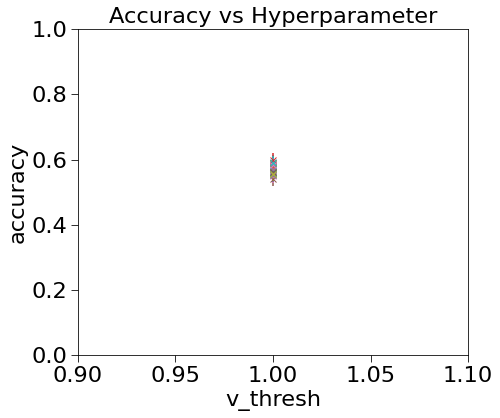

In [7]:
config = create_base_config()
config_path = write_config(config_name='config', config=config)

# Split dataset
x_train, x_test, y_train, y_test = train_test_split(
            features, labels, test_size=0.25, random_state=0, shuffle=True
        )
# save test and normalization data for SNN Toolbox
logging.debug('Saving test data...')
np.savez_compressed(os.path.join(path_wd, 'x_test'), x_test)
np.savez_compressed(os.path.join(path_wd, 'y_test'), y_test)
  np.savez_compressed(os.path.join(path_wd, 'x_norm'), x_train[::10])

# Monte-Carlo cross-validation
shuffle_split = ShuffleSplit(
    n_splits=30,
    test_size=0.25,
    random_state=0
)

es = keras.callbacks.callbacks.EarlyStopping(
    patience=5, verbose=1, restore_best_weights=True)

counter = 0
# Containers for result objects
val_metrics = []
test_metrics = []
snn_metrics = []

# The cross-validation loop
for train, validation in shuffle_split.split(x_train):
  logging.info('Iteration {}'.format(counter))
  ann_model = create_model()
  val_metrics.append(
      ann_model.fit(
        x=x_train[train], 
        y=y_train[train],
        callbacks=[es],
        shuffle=True,
        epochs=30,
        batch_size=16,
        validation_data=(x_train[validation], y_train[validation])
    ))
  ann_res = ann_model.evaluate(x_test, y_test)
  test_metrics.append(ann_res)
  print('test accuracy: {}'.format(ann_res))
  logging.info('Saving ANN model...')
  ann_model.save(os.path.join(
      path_wd, ''.join([model_name, model_ext])))
  logging.info('Converting ANN to SNN...')
  snn_metrics.append(main(config_path))
  counter += 1
  logging.debug('end of iteration {}...'.format(counter))

logging.info('Saving results to {}'.format(path_wd))
np.savez_compressed(os.path.join(path_wd, 'val_metrics'), np.array(val_metrics))
np.savez_compressed(os.path.join(path_wd, 'ann_metrics'), np.array(test_metrics))
np.savez_compressed(os.path.join(path_wd, 'snn_metrics'), np.array(snn_metrics))
logging.debug('Finished')

   Iteration   ANN-acc   SNN-acc
0          0  0.647586  0.576904
1          1  0.644599  0.564460
2          2  0.637133  0.572922
3          3  0.619711  0.577899
4          4  0.639622  0.590343
           ANN       SNN
mean  0.637000  0.571993
std   0.006647  0.015589
   Iteration    Model  Accuracy
0          0  ANN-acc  0.647586
1          1  ANN-acc  0.644599
2          2  ANN-acc  0.637133
3          3  ANN-acc  0.619711
4          4  ANN-acc  0.639622


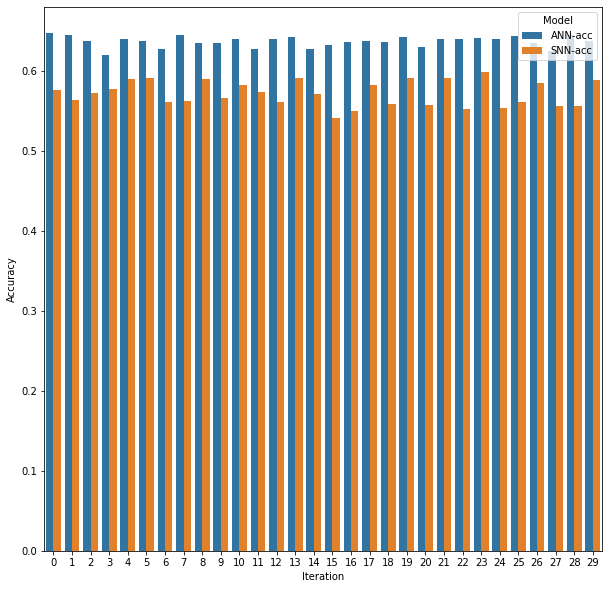

In [43]:
# Processing and visualisation of results
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Uncomment to use arbitrary saved results
# test_metrics = np.load('/content/drive/My Drive/temp/gtn/2020-04-30 15:05:49.615516/ann_metrics.npz')['arr_0'][:, 1:]
# snn_metrics = np.load('/content/drive/My Drive/temp/gtn/2020-04-30 15:05:49.615516/snn_metrics.npz')['arr_0']

iterations = np.expand_dims(np.arange(30), 1)
metrics = np.hstack((iterations, test_metrics, snn_metrics))
metrics_df = pd.DataFrame(metrics, columns=['Iteration', 'ANN-acc', 'SNN-acc'])
metrics_df['Iteration'] = metrics_df['Iteration'].astype(int)

# Compute average accuracy over all iterations
ann = metrics_df['ANN-acc']
snn = metrics_df['SNN-acc']
ann_mean = ann.mean(axis=0)
snn_mean = snn.mean(axis=0)

# Compute standard deviation
ann_std = ann.std(axis=0)
snn_std = snn.std(axis=0)

characteristics = pd.DataFrame(
    {'ANN':{'mean':ann_mean, 'std':ann_std},
     'SNN':{'mean':snn_mean, 'std':snn_std}})
print(characteristics)

metrics_df = metrics_df.melt(id_vars='Iteration', value_vars=['ANN-acc', 'SNN-acc'], var_name='Model', value_name='Accuracy')

# Plot accuracies across iterations
fig, ax1 = plt.subplots(figsize=(10, 10))
sns.barplot(x='Iteration', y='Accuracy', hue='Model', data=metrics_df, ax=ax1)
plt.savefig('/content/drive/My Drive/temp/gtn/2020-04-30 15:05:49.615516/graph.svg', format='svg')
plt.show()